##Voice antispoofing classificantion task with ASV dataset: https://datashare.ed.ac.uk/handle/10283/3336

##Imports

In [ ]:
!pip install wandb

import copy
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from typing import Optional
import torch
import torch.nn as nn
import torchaudio
import librosa
import sklearn.metrics as metrics
import wandb
from torchvision.models import resnet50, resnet18
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

In [2]:
# https://wandb.ai/quickstart

!wandb login 967321168fca31027bb8683f84f421b9bcfd4bd0

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
wandb.init(project="voice-anti-spoofing", name = "test_run", tags = ["SmallModel", "LA"])

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


##Dataframe creation and Data observation

In [8]:
# to make dataframes
path_la_train = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
path_la_dev = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
path_la_eval = "for_collab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

flac_la_train = "for_collab/train_flac/"
flac_la_dev = "for_collab/flac_dev/"
flac_la_eval = "for_collab/flac_eval/"

In [9]:
columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
df = pd.read_csv(path_la_train, sep=" ", header=None)
df.columns = columns
df.head()

,speaker_id,audio_file_name,system_id,skip,class
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


In [10]:
def make_df(txt_file_path, flac_path):
        name = 'ASVspoof2019LA'
        attack_name = 'deepfake'

        df = pd.read_csv(txt_file_path, sep=" ", header=None)

        df.columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
        df['dataset'] = name
        di = {'bonafide':0, 'spoof':1} # assign classes

        q = os.listdir(flac_path)
        q = [j.split('.')[0] for j in q]
        df = df[df['audio_file_name'].isin(q)]

        df['class'] = df['class'].map(di)
        df['audio_path'] = flac_path + df['audio_file_name'] + '.flac'
        df = df[["speaker_id", "audio_path", "class"]]

        df = df[["speaker_id", "audio_path", "class"]]
        df = df.reset_index(drop=True)
        return df

In [12]:
df_dev = make_df(path_la_dev, flac_la_dev)
df_dev['class'].value_counts()

1    328
Name: class, dtype: int64

I'm using reduced version of data and I found out that df_dev have only 'spoof' class, so I decided to concat it with eval and after this split into two separate dataframes

In [14]:
from sklearn.utils import shuffle
df_train = make_df(path_la_train, flac_la_train)
df_eval = make_df(path_la_eval, flac_la_eval)
df_test = pd.concat([df_dev,df_eval])
df_test = df_test.sample(frac=1)

In [15]:
df_test.head()

,speaker_id,audio_path,class
104,LA_0075,for_collab/flac_dev/LA_D_6846844.flac,1
43,LA_0039,for_collab/flac_eval/LA_E_2074204.flac,0
196,LA_0072,for_collab/flac_dev/LA_D_2731036.flac,1
37,LA_0074,for_collab/flac_dev/LA_D_9646783.flac,1
226,LA_0077,for_collab/flac_dev/LA_D_3549647.flac,1


In [40]:
l = int(0.2 * df_test.shape[0])
df_val = df_test.iloc[:l].reset_index()
df_test = df_test.iloc[l:].reset_index()

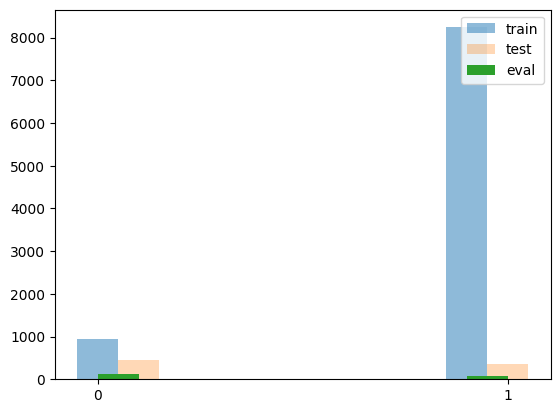

In [18]:
plt.hist(df_train['class'],alpha=0.5,label='train',align='left')
plt.hist(df_test['class'],alpha=0.3,label='test',align='right')
plt.hist(df_val['class'],alpha=1,label='eval',align='mid')
plt.legend(loc='upper right')
plt.xticks([0, 1])
plt.show()

In [20]:
#To balance classes we will count weights for each class, for majority class '1' in ourt case in will be 1, so for '0'
print("weight for class='1':",df_train[df_train['class']==0].shape[0]/df_train[df_train['class']==1].shape[0])
weights = [1/0.1147,1]

weight for class='1': 0.11468446601941748


Data distribution is imbalanced minority class is just 11% of majority data. To fix it we will add weights to Loss for each class. Idea to use undersampling not best, because we are losing about bcs we will lose about 80% of our data. Oversampling also not so good, bcs we will learn our model on same data at many cases, this can lead to overfitting. Add new data is a difficult task, which will increase computational time (I have not so many time to compelete this task), so my choice is to balance the classes by weights in Loss fucntion

In [21]:
x, sr = torchaudio.load(df_eval["audio_path"].iloc[0])
df_test = df_test.sample(frac=1)

In [22]:
#lets find speaker with both classes of tracks
df_test[df_test['speaker_id']=='LA_0010']['class'].value_counts()

0    11
1     3
Name: class, dtype: int64

In [23]:
bona_fide = df_eval[(df_eval['class']==0) & (df_eval['speaker_id']=='LA_0020')]['audio_path'].head(2)
spoof = df_eval[(df_eval['class']==1) & (df_eval['speaker_id']=='LA_0020')]['audio_path'].head(2)

In [24]:
#Bona_fide for speaker LA_0010
print('Bona_fide')
for track in bona_fide:
  x, sr = torchaudio.load(track)
  ipd.display(ipd.Audio(x, rate=sr))
print('Spoof')
for track in spoof:
  x, sr = torchaudio.load(track)
  ipd.display(ipd.Audio(x, rate=sr))

Bona_fide


Spoof


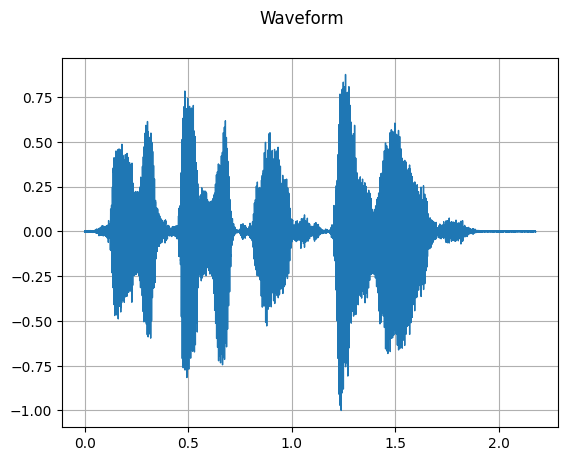

In [25]:
x.shape
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)
plot_waveform(x,sr)

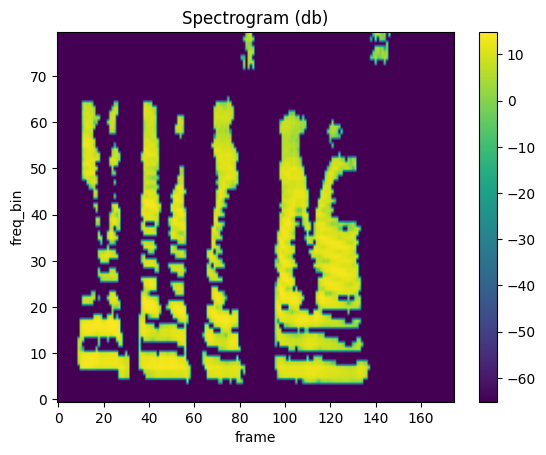

In [26]:
Mel = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=80)
To_db = torchaudio.transforms.AmplitudeToDB()
spec = To_db((Mel(x)))
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
plot_spectrogram(spec[0])

##Model and Dataloader initialization

In [27]:
class WavResNet(nn.Module):
    def __init__(self, classes=2, resample=16000, n_mels=80, melspec_config=None):
        super().__init__()
        if melspec_config==None:
          self.fbank = torchaudio.transforms.MelSpectrogram(sample_rate=resample, n_mels=80)
        else:
          self.fbank = torchaudio.transforms.MelSpectrogram(**melspec_config)

        self.to_db = torchaudio.transforms.AmplitudeToDB()



        model = resnet18()
        model.conv1 = torch.nn.Conv2d(1, 64,kernel_size=model.conv1.kernel_size,stride=2,padding=1)
        self.num_ftrs = model.fc.in_features
        model.fc = nn.Linear(self.num_ftrs,classes)

        self.network = model



    def forward(self, x, wav_lens: Optional[torch.Tensor]=None):
        mels = torch.abs(self.fbank(x))
        mels_db = self.to_db(mels)
        out = self.network(mels_db)
        return out

It's easier to use BCE loss which was designed specialy for binary classification problem. But, in feature if model will be rebuild for multiclass problem deal with Cross entropy will be much easier (for example different types of voice attacks)
*2.4* I'm not sure that it's good idea, because some augmentaions can be look like attacks.

In [29]:
class DatasetWav(Dataset):

    def __init__(self, data_frame, padding_sec=4, default_sr=16000, transform=None):
        self.df = data_frame
        self.padding_sec = padding_sec
        self.default_sr = default_sr
        self.labels = self.df['class']
        self.paths = self.df['audio_path']
        self.vad = torchaudio.transforms.Vad(sample_rate=self.default_sr, trigger_level=10)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.labels[idx]
        path = self.paths[idx]
        waveform , sr = torchaudio.load(path,normalize=True) # normalize=True
        # transform waveform from stereo to mono channel
        if waveform.shape[0]>1:
          waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sr!=self.default_sr:
          resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.default_sr)
          waveform = resample_transform(waveform)


        if (waveform.shape[1] < self.padding_sec * self.default_sr):
          dif = self.padding_sec * self.default_sr - waveform.shape[1]
          zeros = torch.zeros(1,dif)
          x = torch.cat((waveform,zeros),dim=1)
        else:
          x = waveform[:,:self.padding_sec*self.default_sr]
        return x, torch.tensor(label)

In [30]:
batch_size = 4
train_dataset_wavs = DatasetWav(df_train)
next(iter(train_dataset_wavs))
train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
x, y = next(iter(train_dataloader_wavs))
model = WavResNet(classes=2)
model(x)
print(y)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([1, 0, 1, 1])


In [101]:
def train(model, dataloaders, criterion, optimizer,
          num_epochs=3, scheduler=None, savename=None,
          print_counter=10, decay_factor=10,
          device=torch.device("cuda")):

  if device==None:
    device=torch.device('cuda')
  model.to(device)
  data_t = dataloaders['train']
  data_v = dataloaders['val']
  loss_lst = []
  val_acc_lst = []
  #iterate per epoch
  for epoch in range(num_epochs):
    model.train(True)
    #iterate per batch
    for i,(data, labels) in enumerate(tqdm(data_t)):

        data, labels = data.to(device), labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        pred = torch.max(output,1).indices
        optimizer.zero_grad()
        loss_item = loss.detach().item()
        loss.backward()
        optimizer.step()

        loss_lst.append(loss_item)
        acc = torch.sum(pred==labels)/len(labels)
        if i//50 > 0 and i%50==0:

          print(f'Loss{loss_item},accuracy:{acc}')
    print('-----------------------------------------')
    #validation
    y, proba, val_acc = test(model, data_v,
                                       device=device,savename=savename,
                                       name='val')
    val_acc_lst.append(val_acc)
  return model, loss_lst, val_acc_lst


def test(model, test_dataloader,device=None, savename=None,name = 'test'):
  print(f'{name} started')
  if device==None:
    device=torch.device('cuda')
  model.to(device)
  loss_test = 0
  acc_test = 0
  y = []
  proba = []
  model.eval()
  for batch_num, (data,labels) in enumerate(test_dataloader):

        data, labels = data.to(device), labels.to(device)
        output = model(data)
        pred = torch.max(output,1).indices
        proba.append(pred)
        y.append(labels)
        acc = torch.sum(pred==labels) / len(labels)
        acc_test += acc

  test_accuracy = acc_test/(batch_num+1)
  print()
  print(f'{name} accuracy: {test_accuracy}')
  return y,proba,test_accuracy

### Train and test loop

In [107]:
def main(config=None):
    if not(config):
      lr =  10**(-4)
      epochs = 3
      batch_size = 64

    wandb.config = {
      "learning_rate": lr,
      "epochs": epochs,
      "batch_size": batch_size
    }


    train_dataset_wavs = DatasetWav(df_train)
    train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size,shuffle=True)
    val_dataset_wavs = DatasetWav(df_val)
    val_dataloader_wavs = DataLoader(val_dataset_wavs, batch_size=batch_size,shuffle=True)
    dataloaders = {"train": train_dataloader_wavs, "val": val_dataloader_wavs}


    device = 'cuda'
    classes = 2
    model = WavResNet()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    alpha = 0.11
    sc = torch.tensor(weights).to(device) # weights for loss
    criterion = nn.CrossEntropyLoss(weight=sc)


    model, loss, val_acc_history = train(model = model,
                                  dataloaders = dataloaders,
                                  criterion = criterion,
                                  optimizer = optimizer,
                                  num_epochs = epochs,
                                  device = device)



    return model, loss, val_acc_history
model,loss,val_acc = main()

 35%|███▌      | 51/144 [00:11<00:20,  4.47it/s]

Loss0.16267862915992737,accuracy:0.9375


 71%|███████   | 102/144 [00:23<00:09,  4.41it/s]

Loss0.1383567899465561,accuracy:0.984375


100%|██████████| 144/144 [00:31<00:00,  4.52it/s]


-----------------------------------------
val started

val accuracy: 0.885565459728241


 35%|███▌      | 51/144 [00:11<00:20,  4.48it/s]

Loss0.09794601052999496,accuracy:1.0


 71%|███████   | 102/144 [00:23<00:09,  4.61it/s]

Loss0.010221154429018497,accuracy:1.0


100%|██████████| 144/144 [00:32<00:00,  4.48it/s]


-----------------------------------------
val started

val accuracy: 0.9340774416923523


 35%|███▌      | 51/144 [00:11<00:21,  4.41it/s]

Loss0.003218367462977767,accuracy:1.0


 70%|███████   | 101/144 [00:22<00:09,  4.44it/s]

Loss0.039218008518218994,accuracy:1.0


100%|██████████| 144/144 [00:32<00:00,  4.47it/s]


-----------------------------------------
val started

val accuracy: 0.9427083730697632


In [114]:
loss_it = [i for i in range(len(loss))]
val_it = np.linspace(0,len(loss),3)
val_acc = [i.cpu().detach().numpy()  for i in val_acc]

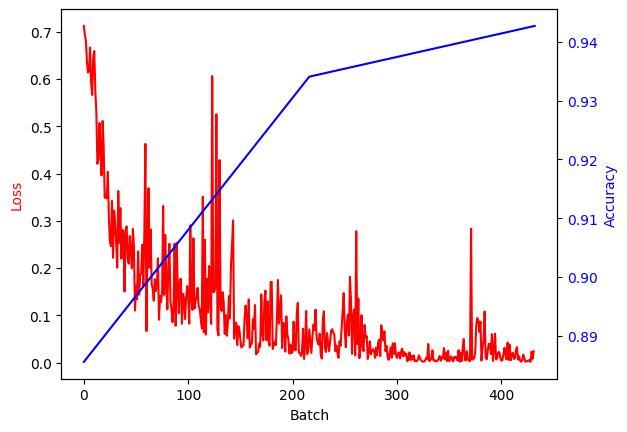

In [116]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss', color = 'red')
ax1.plot(loss_it, loss, color = 'red')
ax2 = ax1.twinx()

ax2.set_ylabel('Accuracy', color = 'blue')
ax2.plot(val_it, val_acc, color = 'blue')
ax2.tick_params(axis ='y', labelcolor = 'blue')

In [128]:
test_dataset_wavs = DatasetWav(df_test)
test_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=1, shuffle=True)
y,proba,test_accuracy = test(model,test_dataloader_wavs)

test started

test accuracy: 0.9994556903839111


In [139]:
error = []
for pred,true in zip(proba,y):
  pred,true = pred[0].cpu().detach().numpy(),true[0].cpu().detach().numpy()
  if not pred == true:
    if true == 0:
      name = 'bonafide'
    else:
      name = 'spoof'
    error.append(name)

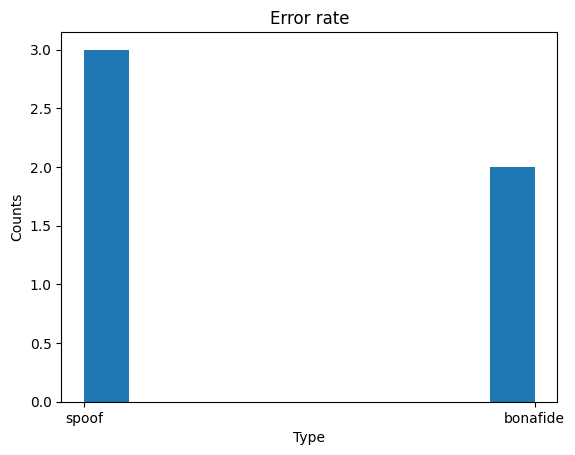

In [141]:
plt.hist(error)
plt.xlabel('Type')
plt.ylabel('Counts')
plt.title('Error rate')
plt.show()